# SuppMat 3: Benchmarking the different model families

Tanya Strydom [](https://orcid.org/0000-0001-6067-1349)  
May 14, 2024

This notebook is going to visualise and further describe the process of benchmarking the different model families. The core code used to download, clean, and summarise the different networks can be found at the following repository [BecksLab/topology_generators](https://github.com/BecksLab/topology_generators).

## Specific models used

The table below shows which specific use-case we use for the network prediction task

| Model family       | Model             | Reference                               |
|---------------------------------|------------------|----------------------|
| null               | Type I model      | @fortunaHabitatLossStructure2006        |
| neutral            |                   | @pomeranzInferringPredatorPrey2019      |
| resource           | undecided         |                                         |
| generative         | MaxEnt model      | @banvilleWhatConstrainsFood2023         |
| energetic          | ADBM              | @petcheySizeForagingFood2008            |
| graph embedding    | Transfer learning | @strydomFoodWebReconstruction2022       |
| trait matching     | PFIM              | @shawFrameworkReconstructingAncient2024 |
| binary classifiers |                   |                                         |
| expert knowledge   |                   |                                         |
| data scavenging    |                   |                                         |
| co-occurrence      |                   |                                         |

## Datasets used

Note that not all datasets are suitable for use with all model families - this is primarily because some of the model families require a lot more additional (external) data and we cannot feasibly do this for all of the available datasets. Conversely for some of the ‘data light’ models it is of course possible to use many networks and create a large sample of networks. Below we will introduce three broader groups of datasets and in the table below we show for which families we used which datasets.

| Model family       | Mangal | New Zealand | Empirical |
|--------------------|--------|-------------|-----------|
| null               | Yes    | yes         | yes       |
| neutral            |        | yes         | yes       |
| resource           | Yes    | yes         | yes       |
| generative         | Yes    | yes         | yes       |
| energetic          |        | yes         | yes       |
| graph embedding    |        |             | yes       |
| trait matching     |        |             | yes       |
| binary classifiers |        |             | yes       |
| expert knowledge   |        |             | yes       |
| data scavenging    |        |             | yes       |
| co-occurrence      |        |             | yes       |

### Mangal networks

We queried the Mangal \[@poisotMangalMakingEcological2016\] database and extracted a total of **TODO** networks. \[*Some sort of summary as to the geographic/taxonomic range??\]* Although these networks represent a high volume of interaction data they do not have accompanying ‘metadata’ that we would need for some of the more data-hungry model families (*e.g.,* local abundance), the Mangal networks were used to provide the ‘starting values’ for the random, resource, and generative families. This allows us to generate a large number of different networks that we can use to compare and contrast the performance of the various model families. For each network from Mangal we generated **TODO** versions of that network using each model family.

> “These complex food webs differ in their level of resolution and sampling effort, which may introduce noise in the estimation of their properties, especially given their large number of interacting elements. However, because our MaxEnt models are applied on imperfect data, they aim at reproducing the sampled structure of food webs, not their actual structure.” - @banvilleWhatConstrainsFood2023 (something to think about…)

### New Zealand dataset

Data from @pomeranzInferringPredatorPrey2019. **TODO** quick outline of what the dataset entails…

### Empirical networks

> Here I think we need to span a variety of domains, at minimum aquatic and terrestrial but maybe there should be a ‘scale’ element as well *i.e.,* a regional and local network. I think there is going to be a ‘turning point’ where structural will take over from mechanistic in terms of performance. More specifically at local scales bioenergetic constraints (and co-occurrence) may play a bigger role in structuring a network whereas at the metaweb level then mechanistic may make more (since by default its about who can potentially interact and obviously not constrained by real-world scenarios) *sensu* @caronTraitmatchingModelsPredict2024. Although having said that I feel that contradicts the idea of backbones (*sensu* Bramon Mora (sp?) et al & Stouffer et al) But that might be where we get the idea of core *structure* vs something like linkage density. So core things like trophic level/chain length will be conserved but connectance might not (I think I understand what I’m trying to say here)

## Predicting models

For each model and network combination we predicted the model **TODO** number of times - this allows us to capture some of the inherent variability (and stochasticity) that we would expect from some of the models.

## Model benchmarking

Some of the considerations one needs to make when wanting to benchmark models is discussed in Box 2 of the main text. The different benchmarking summary statistics that we are collecting are as follows:

For ‘structure’:

-   **Links:** to determine if the number of links are ‘correct’ we use *connectance*

-   *Shape:* to determine if the ‘shape’ of the network is correct we are looking at the ratio of ‘top’:‘basal’ species (where ‘top’ species are those that have a vulnerability of 0 and ‘basal’ species have a generality of 0) as well as the distance to base from one of the top species (this will represent the shortest path but a large discrepancy between the real and predicted network would be indicative that the model is not predicting a similar ‘shape’). This will allow is to see if the models construct tall ‘pencil’ vs flat ‘pancake’ networks (Beckerman 2024, pers comms).

    -   A small (\< 1) number will thus be indicative of a ‘bottom-heavy’ network and the opposite for larger numbers

-   **Structure:** to determine if we are capturing some higher level of ‘structure’ we are using SVD entropy \[@strydomSVDEntropyReveals2021\]

-   *Motifs:* We can estract the motifs identified by @stoufferEvidenceExistenceRobust2007, namely:

    -   S1: Number of linear chains

    -   S2: Number of omnivory motifs

    -   S4: Number of apparent competition motifs

    -   S5: Number of direct competition motifs

For interactions:

Based on @poisotGuidelinesPredictionSpecies2023: - Precision-Recall (PR-AUC) - performance - Matthews correlation coefficient (MCC) - accuracy

## Visualising results

Now it is time to visualise the data

In [ ]:
#| include: false
#| warning: false
library(ggradar)
library(patchwork)
library(scales)
suppressPackageStartupMessages(library(tidyverse))

# download file from other repo
download.file("https://raw.githubusercontent.com/BecksLab/topology_generators/main/data/processed/topology_summary.csv", "../notebooks/data/topology_models.csv")
download.file("https://raw.githubusercontent.com/BecksLab/topology_generators/main/data/processed/mangal_summary.csv", "../notebooks/data/mangal_summary.csv")
download.file("https://raw.githubusercontent.com/BecksLab/topology_generators/main/data/processed/nz_summary.csv", "../notebooks/data/nz_summary.csv")


df = full_join(rbind(read.csv("data/mangal_summary.csv"),
                     read.csv("data/nz_summary.csv")),
                read.csv("data/topology_models.csv")) %>% 
        filter(complexity != 0) %>% 
        # to get the ratio
        mutate(ratio = top/basal,
                top = NULL,
                basal = NULL,
                ratio_mod = top_mod/basal_mod,
                top_mod = NULL,
                basal_mod = NULL) %>%
        pivot_longer(
            cols = c(complexity, distance, connectance, ratio, S1, S2, S4, S5), 
            names_to = "real",
            values_to = "real_val")  %>% 
        pivot_longer(
            cols = c(complexity_mod, distance_mod, connectance_mod, ratio_mod, S1_mod, S2_mod, S4_mod, S5_mod), 
            names_to = "test",
            values_to = "model_val")  %>% 
        mutate(
            real = str_extract(real, "[^_]*"),
            test = str_extract(test, "[^_]*"))  %>% 
        filter(real == test) %>%
        ungroup() %>% 
        filter(model_val != Inf)

Joining with `by = join_by(id)`

Lets start by summarising the ‘raw’ data as box plots just to see what it looks like before we try and do a more streamlines summary

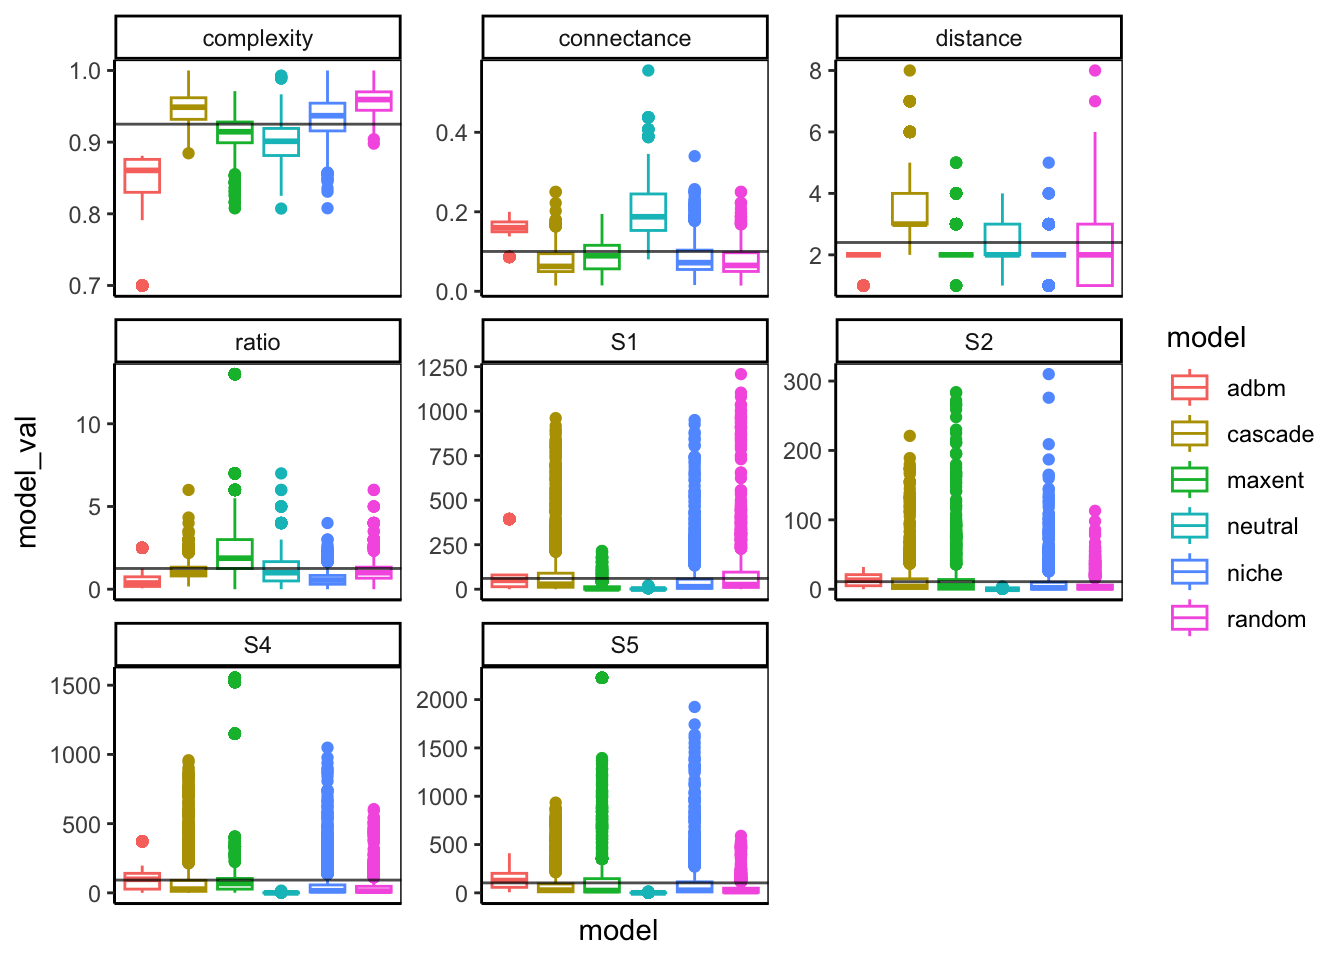

In [ ]:
#| warning: false
#| echo: false
#| label: fig-boxplot
#| fig-cap: "Boxplot looking at raw values for each measurement for each model. The horizontal line represents the true overall mean for each measurement"

ggplot(df) +
#  geom_jitter(aes(x = model,
#                 y = model_val,
#                 colour = model),
#             alpha = 0.4,
#             fill = "#ffffff00", 
#             stroke = 0.2,
#             width = 0.25,
#             shape = 21) +
    geom_boxplot(aes(x = model,
                    y = model_val,
                    colour = model),
                fill = "#ffffff00") +
    geom_hline(data = df  %>% 
                        group_by(real)  %>% 
                        reframe(mu_sim = mean(model_val, na.rm = TRUE)),
                aes(yintercept = mu_sim),
                alpha = 0.7) +
    facet_wrap(vars(real),
                scales = 'free') +
    scale_size(guide = 'none') +
    theme_classic() +
    theme(panel.border = element_rect(colour = 'black',
                                      fill = "#ffffff00"),
            axis.text.x = element_blank(),
            axis.ticks.x = element_blank())

Now we can look at the difference between the mean of the real network property and the simulated one. I had originally considered using the $Z$-score but it doesn’t work well for the more ‘deterministic’ models (neutral and ADBM) because they effectively have a $\sigma$ of zero… so we are just looking at the difference between the real value and the mean predicted value for each network.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Saving 7 x 5 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

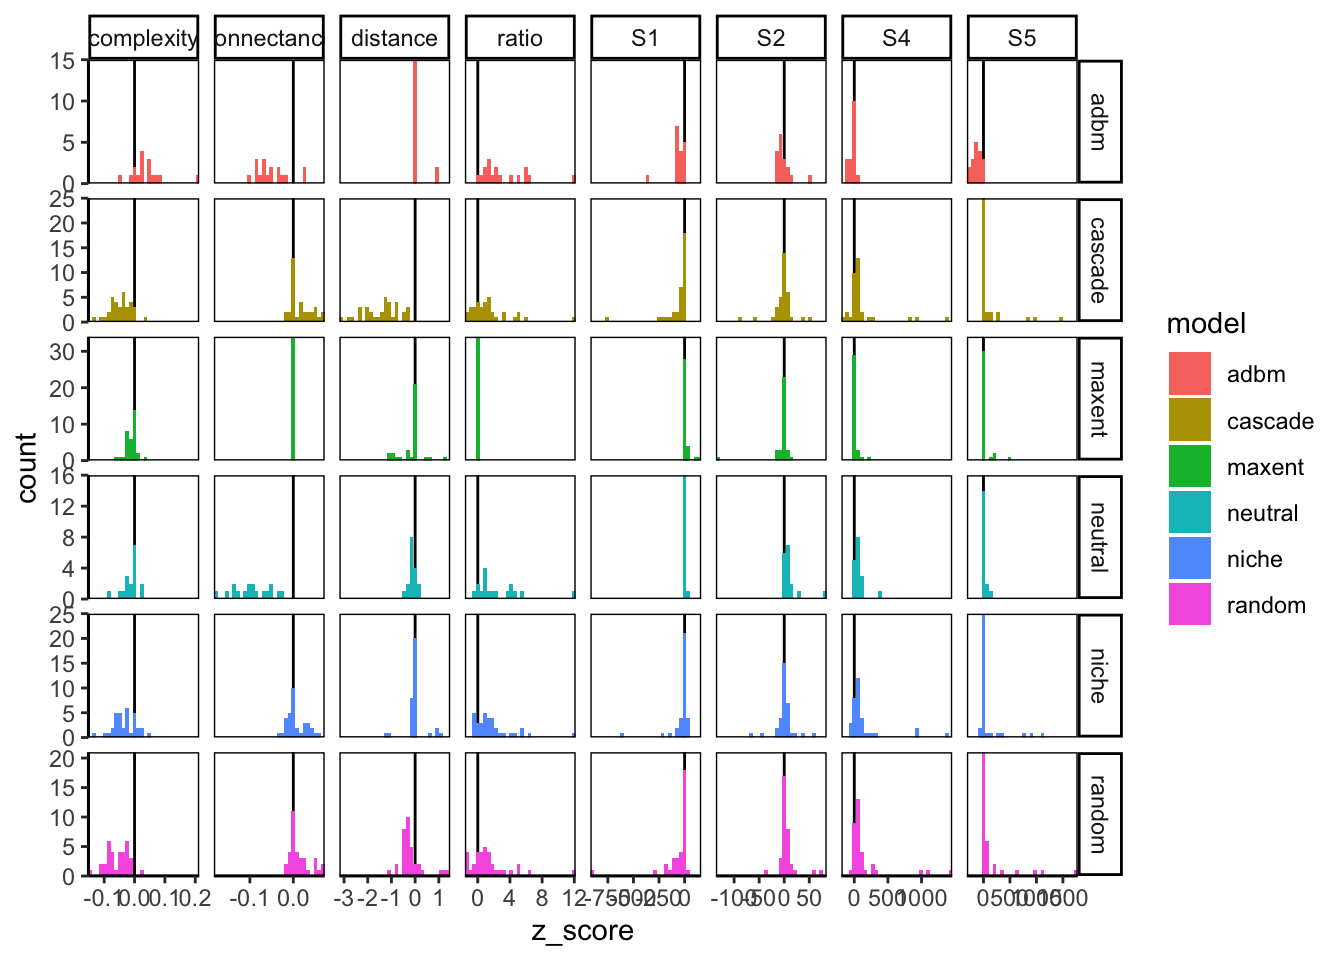

In [ ]:
#| warning: false
#| echo: false
#| label: fig-topology
#| fig-cap: "Difference between real and model network property. S1 - S5 represent the different motif structures identified in @stoufferEvidenceExistenceRobust2007."

ggplot(df %>% 
        group_by(id, real, model)  %>% 
        reframe(x_real = real_val,
                mu_sim = mean(model_val, na.rm = TRUE),
                sd_sim = sd(model_val, na.rm = TRUE)) %>%
        mutate(z_score = (x_real-mu_sim)) %>%
        distinct()) +
    geom_vline(aes(xintercept = 0)) +
    geom_histogram(aes(x = z_score,
                    fill = model),
                colour = "#ffffff00") +
    facet_grid(rows = vars(model),
                cols = vars(real),
                scales = "free") +
    scale_size(guide = 'none') +
    coord_cartesian(expand = FALSE) +
    theme_classic() +
    theme(panel.border = element_rect(colour = 'black',
                                      fill = "#ffffff00"))

(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).
Removed 1 row containing missing values or values outside the scale range

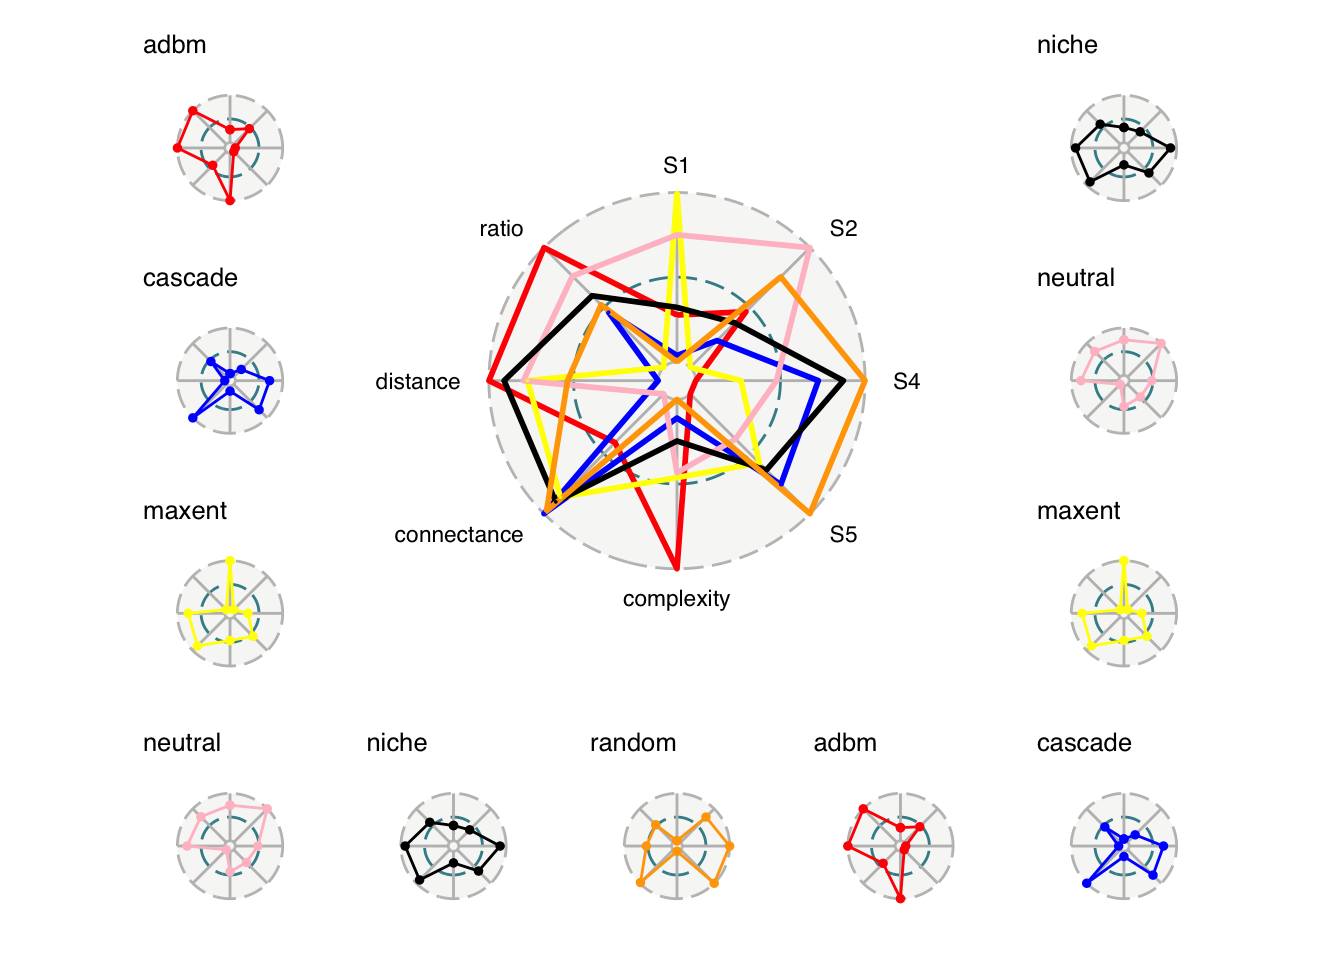

In [ ]:
#| warning: false
#| echo: false
#| label: fig-spider
#| fig-cap: "I was experimenting with radial plots... its not going well.. But in terms of what is currently happening the blue 'inner' circle represents a difference of zero between real and modelled value so ideally we would want the points touching the green circle..."

df_radar <- 
  df %>%
  group_by(id, real, model)  %>% 
        reframe(diff = real_val - model_val) %>%
        distinct() %>% 
        ungroup()  %>% 
        group_by(real, model) %>%
        mutate(diff = mean(diff)) %>%
        select(real, model, diff) %>% 
        distinct() %>% 
        pivot_wider(names_from = real, 
                    values_from = diff) %>%
        ungroup() %>% 
        mutate(across(-model, ~ rescale(.x, 
                                        to = c(-1,1)))) %>% 
        arrange(model)

mod_grp = df_radar %>% distinct(model) %>% pull()
col_mod = c("red", "blue", "yellow", "pink", "black", "orange", "green",
            "purple", "aquamarine", "darkgreen", "deeppink")

data <- vector('list', length(mod_grp))

for (i in 1:length(mod_grp)) {
  
  data[[i]] = ggradar(df_radar %>% 
                      filter(model == mod_grp[i]),
               group.colours = col_mod[i],
               values.radar = NA,
               grid.min = -1,
               grid.mid = 0,
               grid.max = 1,
               group.point.size = 1,
               group.line.width = .5,
               grid.label.size = 3,
               plot.title = mod_grp[i],
               axis.label.size = 0,
               plot.legend = FALSE) +
               theme(title = element_text(size = 8))
  
}

p1 = ggradar(df_radar,
             group.colours = col_mod[1:6],
               grid.min = -1,
               values.radar = NA,
               grid.mid = 0,
               grid.max = 1,
               group.point.size = 0,
               group.line.width = 1,
               axis.label.size = 3)


layout <- "
ALLLK
BLLLJ
CLLLI
DEFGH
"

data[[1]] + 
  data[[2]] + 
  data[[3]] +  
  data[[4]] +
  data[[5]] +
  data[[6]] + 
  data[[1]] +
  data[[2]] + 
  data[[3]] +
  data[[4]] + 
  data[[5]] +
  p1 + 
  plot_layout(design = layout,
              guides = 'collect') & 
  theme(legend.position = 'none',
        legend.text=element_text(size = 4))

## References